# Sampler

In [1]:
from tqdm import tqdm

import torch
import torch.nn.functional as F

from diffusers.utils.torch_utils import randn_tensor

@torch.no_grad()
def sample_stage_1(model,
                   prompt_embeds,
                   negative_prompt_embeds,
                   views,
                   num_inference_steps=100,
                   guidance_scale=7.0,
                   reduction='mean',
                   generator=None):

    # Params
    num_images_per_prompt = 1
    #device = model.device
    device = torch.device('cuda')   # Sometimes model device is cpu???
    height = model.unet.config.sample_size
    width = model.unet.config.sample_size
    batch_size = 1      # TODO: Support larger batch sizes, maybe
    num_prompts = prompt_embeds.shape[0]
    assert num_prompts == len(views), \
        "Number of prompts must match number of views!"

    # For CFG
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

    # Setup timesteps
    model.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = model.scheduler.timesteps

    # Make intermediate_images
    noisy_images = model.prepare_intermediate_images(
        batch_size * num_images_per_prompt,
        model.unet.config.in_channels,
        height,
        width,
        prompt_embeds.dtype,
        device,
        generator,
    )

    for i, t in enumerate(tqdm(timesteps)):
        # Apply views to noisy_image
        viewed_noisy_images = []
        for view_fn in views:
            viewed_noisy_images.append(view_fn.view(noisy_images[0]))
        viewed_noisy_images = torch.stack(viewed_noisy_images)

        # Duplicate inputs for CFG
        # Model input is: [ neg_0, neg_1, ..., pos_0, pos_1, ... ]
        model_input = torch.cat([viewed_noisy_images] * 2)
        model_input = model.scheduler.scale_model_input(model_input, t)

        # Predict noise estimate
        noise_pred = model.unet(
            model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            cross_attention_kwargs=None,
            return_dict=False,
        )[0]

        # Extract uncond (neg) and cond noise estimates
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

        # Invert the unconditional (negative) estimates
        inverted_preds = []
        for pred, view in zip(noise_pred_uncond, views):
            inverted_pred = view.inverse_view(pred)
            inverted_preds.append(inverted_pred)
        noise_pred_uncond = torch.stack(inverted_preds)

                                # Invert the conditional estimates
        inverted_preds = []
        for pred, view in zip(noise_pred_text, views):
            inverted_pred = view.inverse_view(pred)
            inverted_preds.append(inverted_pred)
        noise_pred_text = torch.stack(inverted_preds)

        # Split into noise estimate and variance estimates
        noise_pred_uncond, _ = noise_pred_uncond.split(model_input.shape[1], dim=1)
        noise_pred_text, predicted_variance = noise_pred_text.split(model_input.shape[1], dim=1)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Reduce predicted noise and variances
        noise_pred = noise_pred.view(-1,num_prompts,3,64,64)
        predicted_variance = predicted_variance.view(-1,num_prompts,3,64,64)
        if reduction == 'mean':
            noise_pred = noise_pred.mean(1)
            predicted_variance = predicted_variance.mean(1)
        elif reduction == 'alternate':
            noise_pred = noise_pred[:,i%num_prompts]
            predicted_variance = predicted_variance[:,i%num_prompts]
        else:
            raise ValueError('Reduction must be either `mean` or `alternate`')
        noise_pred = torch.cat([noise_pred, predicted_variance], dim=1)

        # compute the previous noisy sample x_t -> x_t-1
        noisy_images = model.scheduler.step(
            noise_pred, t, noisy_images, generator=generator, return_dict=False
        )[0]

    # Return denoised images
    return noisy_images







@torch.no_grad()
def sample_stage_2(model,
                   image,
                   prompt_embeds,
                   negative_prompt_embeds,
                   views,
                   num_inference_steps=100,
                   guidance_scale=7.0,
                   reduction='mean',
                   noise_level=50,
                   generator=None):

    # Params
    batch_size = 1      # TODO: Support larger batch sizes, maybe
    num_prompts = prompt_embeds.shape[0]
    height = model.unet.config.sample_size
    width = model.unet.config.sample_size
    device = model.device
    num_images_per_prompt = 1

    # For CFG
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

    # Get timesteps
    model.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = model.scheduler.timesteps

    num_channels = model.unet.config.in_channels // 2
    noisy_images = model.prepare_intermediate_images(
        batch_size * num_images_per_prompt,
        num_channels,
        height,
        width,
        prompt_embeds.dtype,
        device,
        generator,
    )

    # Prepare upscaled image and noise level
    image = model.preprocess_image(image, num_images_per_prompt, device)
    upscaled = F.interpolate(image, (height, width), mode="bilinear", align_corners=True)

    noise_level = torch.tensor([noise_level] * upscaled.shape[0], device=upscaled.device)
    noise = randn_tensor(upscaled.shape, generator=generator, device=upscaled.device, dtype=upscaled.dtype)
    upscaled = model.image_noising_scheduler.add_noise(upscaled, noise, timesteps=noise_level)

    # Condition on noise level, for each model input
    noise_level = torch.cat([noise_level] * num_prompts * 2)

    # Denoising Loop
    for i, t in enumerate(tqdm(timesteps)):
        # Cat noisy image with upscaled conditioning image
        model_input = torch.cat([noisy_images, upscaled], dim=1)

        # Apply views to noisy_image
        viewed_inputs = []
        for view_fn in views:
            viewed_inputs.append(view_fn.view(model_input[0]))
        viewed_inputs = torch.stack(viewed_inputs)

        # Duplicate inputs for CFG
        # Model input is: [ neg_0, neg_1, ..., pos_0, pos_1, ... ]
        model_input = torch.cat([viewed_inputs] * 2)
        model_input = model.scheduler.scale_model_input(model_input, t)

        # predict the noise residual
        noise_pred = model.unet(
            model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            class_labels=noise_level,
            cross_attention_kwargs=None,
            return_dict=False,
        )[0]

        # Extract uncond (neg) and cond noise estimates
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

        # Invert the unconditional (negative) estimates
        # TODO: pretty sure you can combine these into one loop
        inverted_preds = []
        for pred, view in zip(noise_pred_uncond, views):
            inverted_pred = view.inverse_view(pred)
            inverted_preds.append(inverted_pred)
        noise_pred_uncond = torch.stack(inverted_preds)

        # Invert the conditional estimates
        inverted_preds = []
        for pred, view in zip(noise_pred_text, views):
            inverted_pred = view.inverse_view(pred)
            inverted_preds.append(inverted_pred)
        noise_pred_text = torch.stack(inverted_preds)

        # Split predicted noise and predicted variances
        noise_pred_uncond, _ = noise_pred_uncond.split(model_input.shape[1] // 2, dim=1)
        noise_pred_text, predicted_variance = noise_pred_text.split(model_input.shape[1] // 2, dim=1)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Combine noise estimates (and variance estimates)
        noise_pred = noise_pred.view(-1,num_prompts,3,256,256)
        predicted_variance = predicted_variance.view(-1,num_prompts,3,256,256)
        if reduction == 'mean':
            noise_pred = noise_pred.mean(1)
            predicted_variance = predicted_variance.mean(1)
        elif reduction == 'alternate':
            noise_pred = noise_pred[:,i%num_prompts]
            predicted_variance = predicted_variance[:,i%num_prompts]

        noise_pred = torch.cat([noise_pred, predicted_variance], dim=1)

        # compute the previous noisy sample x_t -> x_t-1
        noisy_images = model.scheduler.step(
            noise_pred, t, noisy_images, generator=generator, return_dict=False
        )[0]

    # Return denoised images
    return noisy_images

ModuleNotFoundError: No module named 'diffusers'

# Exploring Latent Diffusion

In [2]:
# @title #Install requirements
!pip install -q --upgrade transformers diffusers ftfy mediapy

from base64 import b64encode

import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

import numpy as np
import mediapy as mp
import cv2

from pathlib import Path
from torch import autocast
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.0 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# @title #Load Models
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae", torch_dtype=torch.float16)

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet", torch_dtype=torch.float16)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [27]:
#@title #Helper Functions
import matplotlib.pyplot as plt
def fourier_denoising(im, percent):
    # Denoising a H x W image on GPU, handling float16 data type
    im_float = im.to(torch.float32)  # Convert to float32 for FFT
    f = torch.fft.fft2(im_float)
    thres = torch.quantile(f.abs(), 1 - percent / 100)
    filtered_f = torch.where(f.abs() >= thres, f, torch.zeros_like(f))
    recons = torch.fft.ifft2(filtered_f)
    return recons.real.to(torch.float16)  # Convert back to float16

def fourier_denoising_channelwise(im, percent):
    # Denoising a C x H x W image independently for each channel on GPU, handling float16
    C, H, W = im.shape
    recons = torch.empty_like(im)
    for i in range(C):
        recons[i, :, :] = fourier_denoising(im[i, :, :], percent)
    return recons

def fourier_denoising_cross_channel(im, percent):
    # Denoising a C x H x W image by integrating all channels on GPU, handling float16
    C, H, W = im.shape
    f = torch.empty_like(im, dtype=torch.complex64)
    recons = torch.empty_like(im)
    for i in range(C):
        f[i, :, :] = torch.fft.fft2(im[i, :, :].to(torch.float32))  # Convert to float32 for FFT
    thres = torch.quantile(f.abs(), 1 - percent / 100)
    filtered_f = torch.where(f.abs() >= thres, f, torch.zeros_like(f))
    for i in range(C):
        recons[i, :, :] = torch.fft.ifft2(filtered_f[i, :, :]).real.to(torch.float16)  # Convert back to float16
    return recons



import numpy as np
from scipy import signal
from scipy.interpolate import interp2d

def Motion_illustion(omg, t, I, theta):
    I = (I-np.amin(I))/(np.amax(I)-np.amin(I))

    a = np.linspace(1, I.shape[0], I.shape[0])
    b = np.linspace(1, I.shape[1], I.shape[0])

    up_ratio = 20
    c = np.linspace(1, I.shape[0], I.shape[0]*up_ratio)
    d = np.linspace(1, I.shape[1], I.shape[1]*up_ratio)
    interp_func = interp2d(a, b, I, kind='cubic')
    I_up = interp_func(c, d)

    xr = np.arange(-2, 2.2, 0.2)
    yr = np.arange(-2, 2.2, 0.2)
    x, y = np.meshgrid(xr, yr)

    G_2a = lambda x, y: 0.9213 * (2 * x**2 - 1) * np.exp(-(x**2 + y**2))
    G_2b = lambda x, y: 1.843 * x * y * np.exp(-(x**2 + y**2))
    G_2c = lambda x, y: 0.9213 * (2 * y**2 - 1) * np.exp(-(x**2 + y**2))
    k_ga = lambda theta: np.cos(theta)**2
    k_gb = lambda theta: -2 * np.cos(theta) * np.sin(theta)
    k_gc = lambda theta: np.sin(theta)**2

    H_2a = lambda x, y: 0.9780 * (-2.254 * x + x**3) * np.exp(-(x**2 + y**2))
    H_2b = lambda x, y: 0.9780 * (-0.7515 + x**2) * y * np.exp(-(x**2 + y**2))
    H_2c = lambda x, y: 0.9780 * (-0.7515 + y**2) * x * np.exp(-(x**2 + y**2))
    H_2d = lambda x, y: 0.9780 * (-2.254 * y + y**3) * np.exp(-(x**2 + y**2))
    k_ha = lambda theta: np.cos(theta)**3
    k_hb = lambda theta: -3 * (np.cos(theta)**2) * np.sin(theta)
    k_hc = lambda theta: 3 * np.cos(theta) * (np.sin(theta)**2)
    k_hd = lambda theta: -(np.sin(theta)**3)

    G = lambda theta, x, y: k_ga(theta) * G_2a(x, y) + k_gb(theta) * G_2b(x, y) + k_gc(theta) * G_2c(x, y)
    H = lambda theta, x, y: k_ha(theta) * H_2a(x, y) + k_hb(theta) * H_2b(x, y) + k_hc(theta) * H_2c(x, y) + k_hd(theta) * H_2d(x, y)

    D = lambda omg, t, I, theta, x, y: np.cos(omg * t) * signal.convolve2d(I, G(theta, x, y), mode='same') + np.sin(omg * t) * signal.convolve2d(I, H(theta, x, y), mode='same')

    Img_out_up = D(omg, t, I_up, theta, x, y)
    Img_out_up = Img_out_up[::up_ratio, :]
    Img_out_up = Img_out_up[:, ::up_ratio]
    Img_out = Img_out_up

    a = np.fft.fft2(I)
    b = np.multiply(a,np.exp(1j*Img_out))
    Img_MI = np.fft.ifft2(b)
    Img_MI = Img_MI.real


    return Img_MI


def Motion_illustion_phase(omg, t, I, theta):
    I = (I-np.amin(I))/(np.amax(I)-np.amin(I))

    a = np.linspace(1, I.shape[0], I.shape[0])
    b = np.linspace(1, I.shape[1], I.shape[0])

    up_ratio = 20
    c = np.linspace(1, I.shape[0], I.shape[0]*up_ratio)
    d = np.linspace(1, I.shape[1], I.shape[1]*up_ratio)
    interp_func = interp2d(a, b, I, kind='cubic')
    I_up = interp_func(c, d)

    xr = np.arange(-2, 2.2, 0.2)
    yr = np.arange(-2, 2.2, 0.2)
    x, y = np.meshgrid(xr, yr)

    G_2a = lambda x, y: 0.9213 * (2 * x**2 - 1) * np.exp(-(x**2 + y**2))
    G_2b = lambda x, y: 1.843 * x * y * np.exp(-(x**2 + y**2))
    G_2c = lambda x, y: 0.9213 * (2 * y**2 - 1) * np.exp(-(x**2 + y**2))
    k_ga = lambda theta: np.cos(theta)**2
    k_gb = lambda theta: -2 * np.cos(theta) * np.sin(theta)
    k_gc = lambda theta: np.sin(theta)**2

    H_2a = lambda x, y: 0.9780 * (-2.254 * x + x**3) * np.exp(-(x**2 + y**2))
    H_2b = lambda x, y: 0.9780 * (-0.7515 + x**2) * y * np.exp(-(x**2 + y**2))
    H_2c = lambda x, y: 0.9780 * (-0.7515 + y**2) * x * np.exp(-(x**2 + y**2))
    H_2d = lambda x, y: 0.9780 * (-2.254 * y + y**3) * np.exp(-(x**2 + y**2))
    k_ha = lambda theta: np.cos(theta)**3
    k_hb = lambda theta: -3 * (np.cos(theta)**2) * np.sin(theta)
    k_hc = lambda theta: 3 * np.cos(theta) * (np.sin(theta)**2)
    k_hd = lambda theta: -(np.sin(theta)**3)

    G = lambda theta, x, y: k_ga(theta) * G_2a(x, y) + k_gb(theta) * G_2b(x, y) + k_gc(theta) * G_2c(x, y)
    H = lambda theta, x, y: k_ha(theta) * H_2a(x, y) + k_hb(theta) * H_2b(x, y) + k_hc(theta) * H_2c(x, y) + k_hd(theta) * H_2d(x, y)

    D = lambda omg, t, I, theta, x, y: np.cos(omg * t) * signal.convolve2d(I, G(theta, x, y), mode='same') + np.sin(omg * t) * signal.convolve2d(I, H(theta, x, y), mode='same')

    Img_out_up = D(omg, t, I_up, theta, x, y)
    Img_out_up = Img_out_up[::up_ratio, :]
    Img_out_up = Img_out_up[:, ::up_ratio]
    Img_out = Img_out_up


    return Img_out


def tensor_to_numpy(tensor):
    # Move tensor to CPU and convert to float32 NumPy
    return tensor.detach().cpu().numpy().astype(np.float32)

def numpy_to_tensor(array, device):
    # Convert NumPy array back to tensor, convert to float16, and move to specified device
    return torch.tensor(array, dtype=torch.float16).to(device)

0


<ipython-input-7-526c48ea792f>:42: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

<ipython-input-4-eaa2bd571a67>:48: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_func = interp2d(a, b, I, kind='cubic')
<ipython-input-4-eaa2bd571a67>:49: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids us

,

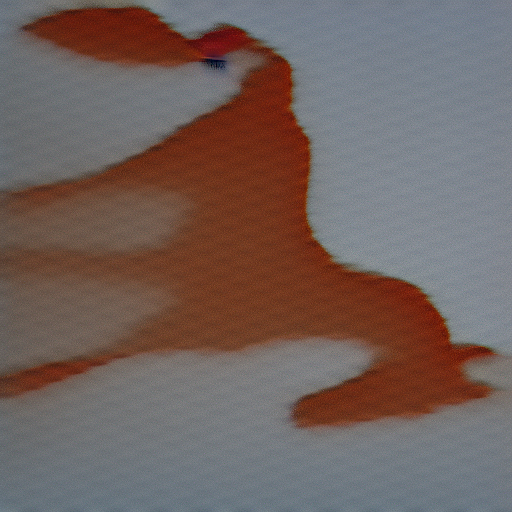
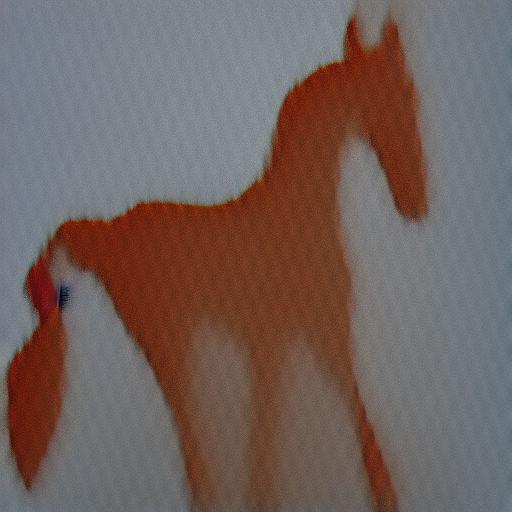

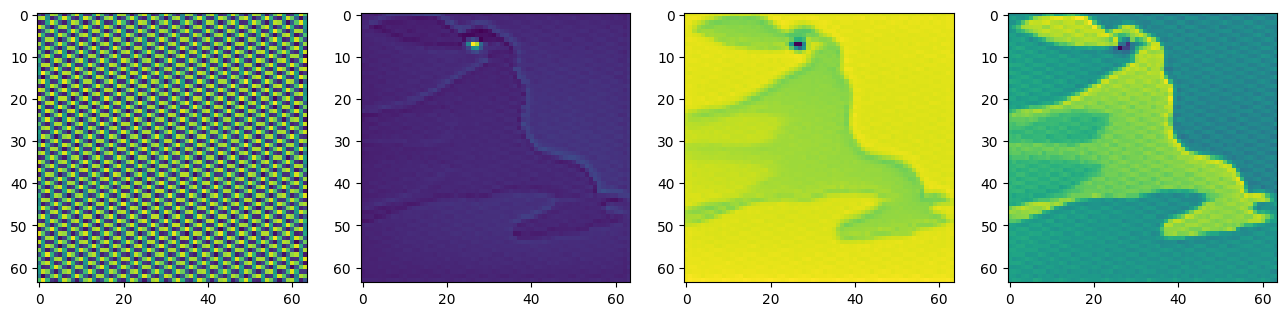

In [ ]:
#@title #Generate Images with Motion Illusion: apply motion illution filter on latent_0
first_prompt = "A cartoon drawing of a horse"
second_prompt = "A cartoon drawing of a snowy mountain village"
rotation_deg = "90"
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
variable_name = False
num_inference_steps = 500
guidance_scale = 7.5
seed = 42
generator = torch.manual_seed(seed)
batch_size = 1
rotate = int(rotation_deg) // 90

# for seed in [0,1,2,3 ,4,5,6,7]:
# 0,3,5
for seed in [0]:
    print(seed)
    generator = torch.manual_seed(seed)

    # Prep text
    text_input = tokenizer([first_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_input_2 = tokenizer([second_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        test_embeddings_2 = text_encoder(text_input_2.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    text_embeddings_2 = torch.cat([uncond_embeddings, test_embeddings_2])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.half() # change float32 to float16
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]
    percent = 40


    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            latents_2 = torch.rot90(latents, rotate, [2, 3]) # only perform transformation on 64x64, which is the last two dimension
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input_2 = torch.cat([latents_2] * 2)

            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            latent_model_input_2 = scheduler.scale_model_input(latent_model_input_2, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings_2).sample
                noise_pred_2 = unet(latent_model_input_2, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            noise_pred_uncond_2, noise_pred_text_2 = noise_pred_2.chunk(2)
            noise_pred_uncond_2 = torch.rot90(noise_pred_uncond_2, -rotate, [2, 3])
            noise_pred_text_2 = torch.rot90(noise_pred_text_2, -rotate, [2, 3])
            noise_pred_2 = noise_pred_uncond_2 + guidance_scale * (noise_pred_text_2 - noise_pred_uncond_2)


            noise_pred_mean = 0.5*noise_pred + 0.5*noise_pred_2



            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred_mean, t, latents).prev_sample

            # apply motion_illution to latent_0
            buff = latents[0][0,:,:]
            buff = buff.cpu().data.numpy()
            test = Motion_illustion(np.pi/num_inference_steps, i, buff, 0.75*np.pi)
            latents[0][0,:,:] = numpy_to_tensor(test,"cuda")

            # latents = torch.unsqueeze(latents, dim=0) # make sure dimension stay the same

            # # the fourier denoising block
            # # followed by a designed scheduler: stepwisely decrease the scales of denoisng.
            # if i>199: # when will the denosing happened
            #   if i%20 == 0: # step size
            #     if i%100==0:
            #       percent = percent+10 # decrease the scale of denoising by adding on the percent of coeffs we want to keep
            #       print(i)
            #       print(percent)
            #     latents = fourier_denoising_channelwise(latents[0], percent) # denoising
            #     latents = torch.unsqueeze(latents, dim=0) # make sure dimension stay the same









# Let's visualize the four channels of this latent representation:
output_latent = 1 / 0.18215 * latents
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(output_latent[0][c].cpu())



# scale and decode the image latents with vae
output_latent = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(output_latent).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")[0, ...]

mp.show_images([image, np.rot90(image, rotate, (0, 1))])

0


<ipython-input-33-7206744ae9d0>:48: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

<ipython-input-27-684da1d180f3>:48: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_func = interp2d(a, b, I, kind='cubic')
<ipython-input-27-684da1d180f3>:49: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids 

,

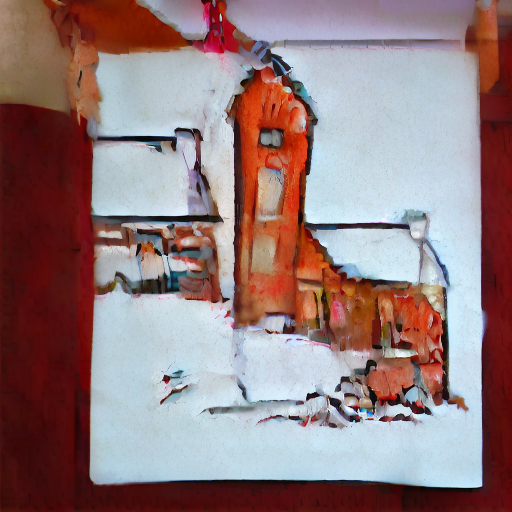
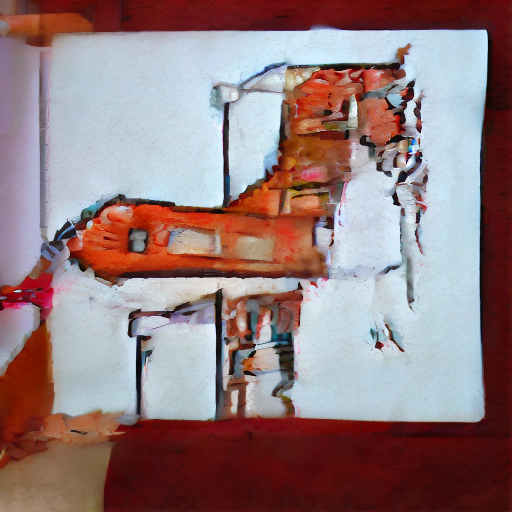

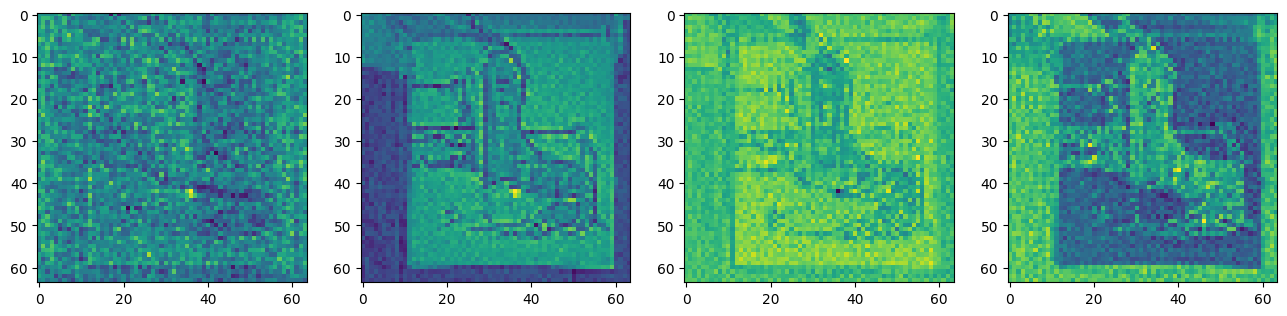

In [33]:
#@title #Generate Images with Motion Illusion: apply motion illution filter on different channel, start from different step, and different step size

mi_channel = 0;
step_start = 410;
step_size = 50;

first_prompt = "A cartoon drawing of a horse"
second_prompt = "A cartoon drawing of a snowy mountain village"
rotation_deg = "90"
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
variable_name = False
num_inference_steps = 500
guidance_scale = 7.5
seed = 42
generator = torch.manual_seed(seed)
batch_size = 1
rotate = int(rotation_deg) // 90


# for seed in [0,1,2,3 ,4,5,6,7]:
# 0,3,5
for seed in [0]:
    print(seed)
    generator = torch.manual_seed(seed)

    # Prep text
    text_input = tokenizer([first_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_input_2 = tokenizer([second_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        test_embeddings_2 = text_encoder(text_input_2.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    text_embeddings_2 = torch.cat([uncond_embeddings, test_embeddings_2])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.half() # change float32 to float16
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]
    percent = 40


    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            latents_2 = torch.rot90(latents, rotate, [2, 3]) # only perform transformation on 64x64, which is the last two dimension
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input_2 = torch.cat([latents_2] * 2)

            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            latent_model_input_2 = scheduler.scale_model_input(latent_model_input_2, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings_2).sample
                noise_pred_2 = unet(latent_model_input_2, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            noise_pred_uncond_2, noise_pred_text_2 = noise_pred_2.chunk(2)
            noise_pred_uncond_2 = torch.rot90(noise_pred_uncond_2, -rotate, [2, 3])
            noise_pred_text_2 = torch.rot90(noise_pred_text_2, -rotate, [2, 3])
            noise_pred_2 = noise_pred_uncond_2 + guidance_scale * (noise_pred_text_2 - noise_pred_uncond_2)


            noise_pred_mean = 0.5*noise_pred + 0.5*noise_pred_2



            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred_mean, t, latents).prev_sample


            # latents = torch.unsqueeze(latents, dim=0) # make sure dimension stay the same


            if i>step_start: # when will the denosing happened
              if i%step_size == 0: # step size
                # apply motion_illution to latent_mi_channel
                buff = latents[0][mi_channel,:,:]
                buff = buff.cpu().data.numpy()
                test = Motion_illustion(np.pi/num_inference_steps, i, buff, 0.75*np.pi)
                latents[0][mi_channel,:,:] = numpy_to_tensor(test,"cuda")
                # latents = torch.unsqueeze(latents, dim=0) # make sure dimension stay the same






# Let's visualize the four channels of this latent representation:
output_latent = 1 / 0.18215 * latents
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(output_latent[0][c].cpu())



# scale and decode the image latents with vae
output_latent = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(output_latent).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")[0, ...]

mp.show_images([image, np.rot90(image, rotate, (0, 1))])

<ipython-input-27-684da1d180f3>:48: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_func = interp2d(a, b, I, kind='cubic')
<ipython-input-27-684da1d180f3>:49: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids 

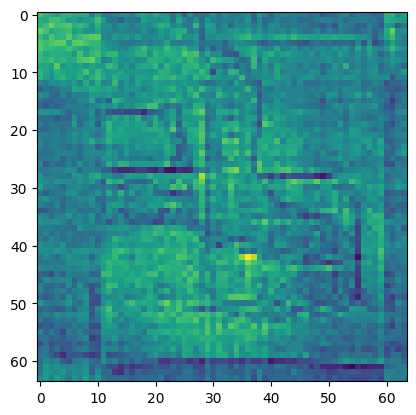

In [34]:
buff = latents[0][1,:,:]
buff = buff.cpu().data.numpy()
test = Motion_illustion(np.pi/num_inference_steps, i, buff, 0.75*np.pi)
plt.imshow(test)
plt.show()

In [6]:
#@title #Debuging
lat0 = latents

In [8]:
lat1 = latents

In [10]:
lat2 = latents

In [12]:
lat3 = latents

,

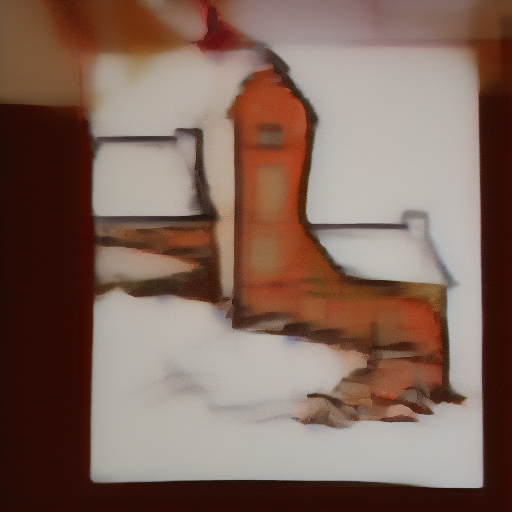
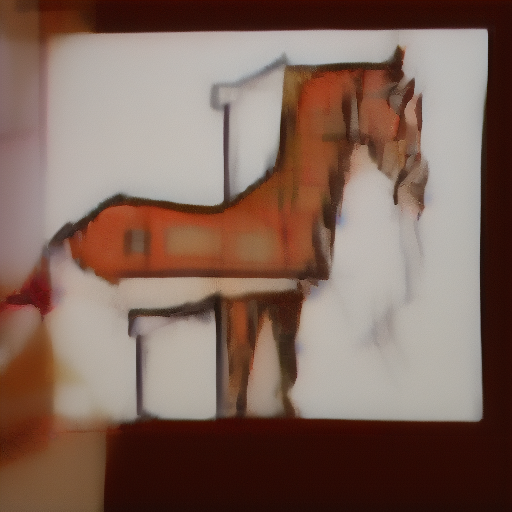

In [13]:
lat = torch.add(lat0,lat1)
lat = torch.add(lat,lat2)
lat = torch.add(lat,lat3)
lat = 0.25*lat
# scale and decode the image latents with vae
output_latent = 1 / 0.18215 * lat
with torch.no_grad():
    image = vae.decode(output_latent).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")[0, ...]

mp.show_images([image, np.rot90(image, rotate, (0, 1))])

In [21]:
with torch.no_grad():
    image = vae.decode(output_latent).sample
with torch.no_grad():
    test = vae.encode(image)

In [25]:
test

AutoencoderKLOutput(latent_dist=<diffusers.models.autoencoders.vae.DiagonalGaussianDistribution object at 0x7d3541b499c0>)